# <div align = "center">LSTM RNN Model - Stock Price Prediction</div>
### <div align = "center"> Author: <a href = "https://www.linkedin.com/in/kamingyip">Kaming Yip</a>&emsp;&emsp;Date July 30, 2021</div>

In this practice, we will apply Long Short-Term Memory (LSTM) network in a time series prediction problem - to predict stock price. The data we use is downloaded directly through <a href = "https://finance.yahoo.com">Yahoo Finance</a> and the time frame is from 2016-01-01 to 2021-07-15.

First, let's install the necessary modules.

In [1]:
# pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


To download the historical price data from the website, we designate the stock name and the time frame we would like to investigate.

In [2]:
def get_stock(ticker, start_date, end_date):
    """
    download the historical data from yahoo web
    & manipulate the data to create desirable columns
    """
    try:
        df = yf.download(ticker, start = start_date, end = end_date)
        df["Date"] = df.index
        df["Date"] = pd.to_datetime(df["Date"])
        df = df[["Date", "Close"]]
        df.index = range(len(df))
        return df
    except Exception as error:
        print(error)
        return None

In [3]:
try:
    ticker = "YELP"
    df = get_stock(ticker, start_date = "2016-01-01", end_date = "2021-07-15")
    print(df.head(10),
          "read {0} lines of data for ticker: {1}".format(len(df), ticker),
          sep = "\n\n")
except Exception as e:
    print(e)
    print("failed to get Yahoo stock data for ticker: {0}".format(ticker),
          end = "\n\n" + "-" * 50 + "\n\n")

[*********************100%***********************]  1 of 1 completed
        Date      Close
0 2016-01-04  27.600000
1 2016-01-05  26.620001
2 2016-01-06  25.910000
3 2016-01-07  25.270000
4 2016-01-08  25.049999
5 2016-01-11  24.309999
6 2016-01-12  23.639999
7 2016-01-13  22.070000
8 2016-01-14  21.590000
9 2016-01-15  21.309999

read 1392 lines of data for ticker: YELP


As shown, we assign the `look_back` as the number of previous time steps to use as input variables to predict the next time period - in this case defaulted to 1. The training data will contain around 67% of the records in the entire dataset and the remaining records will be taken as testing data (plus the last `look_back` recrods in the training data).

In [4]:
look_back = 60
train_size = int(len(df) * 0.67)
train_data = df.iloc[ : train_size, 1:2].values

# Start with the last look_back number of price in the training data
# to predict the first price in test data
test_data = df.iloc[train_size - look_back : , 1:2].values

print("Training Data: {0}".format(train_data.shape),
      "Testing Data: {0}".format(test_data.shape), sep = "\n")

Training Data: (932, 1)
Testing Data: (520, 1)


It's worth noting that LSTMs are sensitive to the scale of the input data. It can be a good practice to rescale the data to the range of \[0, 1\], also called <b>normalizing</b>. We can easily normalize the dataset using the `MinMaxScaler` preprocessing class from the scikit-learn library.

For each dataset (i.e. training and testing), we will split the univariate sequence data into multiple samples, where each sample has `look_back` number of time steps and the output is a single time step. To be more specific, we reshape the data into the following format \[ #samples, #time steps, output dimension \]

In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

X_train, y_train = [], []
for i in range(look_back, train_size):
    X_train.append(train_data_scaled[i - look_back : i, 0])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = [], []
for i in range(look_back, look_back + len(df) - train_size):
    X_test.append(test_data_scaled[i - look_back : i, 0])
    y_test.append(test_data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Now, we will build the LSTM model with 4 hidden layers, where each layer contains 50 blocks or neurons and the output layer makes a single value prediction to predict the normalized stock price for the following day. The network is compiled using the Adam stochastic gradient descent optimizer and the mean squared error (or MSE) loss function. We will train the network for 100 epochs with a batch size of 30. Notice that we add some dropout regularisation in each hidden layers to prevent the network from overfitting. Dropout modifies the network itself by randomly dropping neurons from the network during training in each iteration. When we drop different sets of neurons, it's equivalent to train different neural networks. The different networks will overfit in different ways, so the net effect of dropout will be to reduce overfitting.

Once the model is defined, we can fit it on the training data.

In [6]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True,
               input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = "adam", loss = "mse")

# Fitting the RNN to the training data
model.fit(X_train, y_train, epochs = 100, batch_size = 30)

model.summary()

Epoch 1/100
872/872 [==============================] - 9s 10ms/step - loss: 0.0457
Epoch 2/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0125
Epoch 3/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0109
Epoch 4/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0117
Epoch 5/100
872/872 [==============================] - 5s 5ms/step - loss: 0.0102
Epoch 6/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0101
Epoch 7/100
872/872 [==============================] - 5s 5ms/step - loss: 0.0101
Epoch 8/100
872/872 [==============================] - 5s 5ms/step - loss: 0.0098
Epoch 9/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0098
Epoch 10/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0101
Epoch 11/100
872/872 [==============================] - 5s 5ms/step - loss: 0.0088
Epoch 12/100
872/872 [==============================] - 5s 6ms/step - loss: 0.0089
Epoch 13/100

872/872 [==============================] - 5s 5ms/step - loss: 0.0022
Epoch 100/100
872/872 [==============================] - 5s 5ms/step - loss: 0.0023
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (No

Respectively, we will apply the LSTM model to predict the stock price in training and testing data and visualize the results.

In [7]:
predicted_train = model.predict(X_train)
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test)

train_predict_plot = pd.DataFrame({
        "Date": df["Date"],
        "Close": [np.nan] * len(df)
})
train_predict_plot.loc[look_back : look_back + len(predicted_train) - 1, "Close"] = predicted_train

test_predict_plot = pd.DataFrame({
        "Date": df["Date"],
        "Close": [np.nan] * len(df)
})
test_predict_plot.loc[train_size : train_size + len(predicted_test), "Close"] = predicted_test

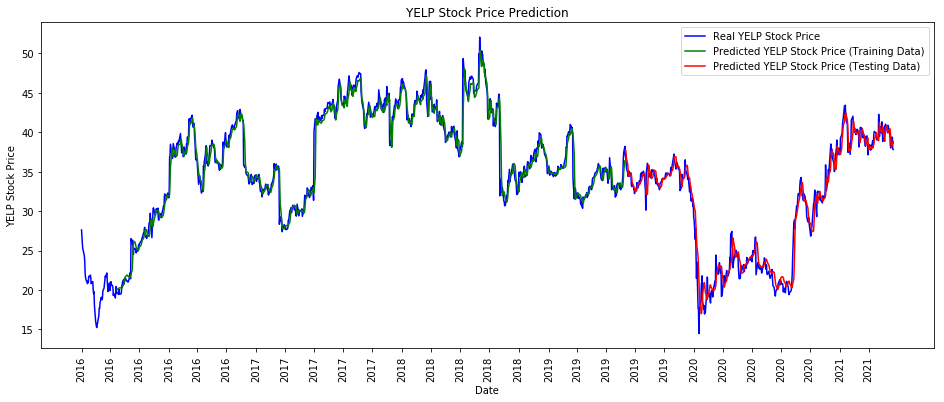

In [8]:
plt.figure(figsize = (16, 6))
plt.plot(df["Date"], df["Close"], color = "blue",
         label = "Real {0} Stock Price".format(ticker))
plt.plot(train_predict_plot["Date"], train_predict_plot["Close"], color = "green",
         label = "Predicted {0} Stock Price (Training Data)".format(ticker))
plt.plot(test_predict_plot["Date"], test_predict_plot["Close"], color = "red",
         label = "Predicted {0} Stock Price (Testing Data)".format(ticker))
plt.xticks(df["Date"][0::50], rotation = "vertical")
plt.title("{0} Stock Price Prediction".format(ticker))
plt.xlabel("Date")
plt.ylabel("{0} Stock Price".format(ticker))
plt.legend()
plt.show()